# Part 0: Data Preparation

In [1]:
!pip install datasets
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [1]:
from datasets import load_dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Part 1: Preparing Word Embeddings

As the first step of building your model, you need to prepare the word embeddings to form the input layer of your model. You are required to choose only from **Word2vec** or **Glove** to initialize your word embedding matrix. The word embedding matrix stores the pre-trained word vectors (taken from Word2vec or Glove) where each row corresponds to a vector for a specific word in the vocabulary formed from your task dataset.set.

In [4]:
import gensim.downloader
import matplotlib.pyplot as plt
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhixu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Question 1. Word Embedding

### (a) What is the size of the vocabulary formed from your training data?

In [7]:
tokens = []
tokenized_sentences = [nltk.tokenize.word_tokenize(sentence['text'].lower()) for sentence in train_dataset]

for sentence in train_dataset:
    tokens.extend(nltk.tokenize.word_tokenize(sentence['text'].lower()))

print ('Number of tokens: '+ str(len(tokens)))

Number of tokens: 183968


In [8]:
# List of all distinct words found in the tokens list
vocab = list(set(tokens))
vocab_size = len(vocab)
print ('Number of token types (Vocabulary Size): '+ str(vocab_size))

Number of token types (Vocabulary Size): 18029


(a) The size of vocabulary formed from the training data is 18029.

### (b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but  not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

In [11]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')
embedding_dim = word2vec_model.vector_size
print("Embedding dimension:", embedding_dim)

Embedding dimension: 300


In [12]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_words = []

# Map vocabulary to embedding matrix
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

for word, idx in word_to_idx.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]
    else:
        # Count OOV words
        oov_words.append(word)

# OOV words count
oov_count = len(oov_words)
print("Number of OOV words:", oov_count)

Number of OOV words: 3612


(b) There are **3612** OOV words in the training data.   

### (c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.

#### Method: Cosine Similarity

Find replacement words for OOV based on cosine similarity. The steps are:
1. Converting the OOV word into a vector (by summing the embeddings of its subwords or by using a neighboring word’s embedding).
2. Selecting replacement candidates based on similarity in the vector space.
3. Calculating cosine similarity between the OOV word and replacement candidates.
4. Choosing a candidate with a high cosine similarity score, ideally close to 1, as the replacement.

(c) We use the **Cosine Similarity** method to handle OOV words. The advantages of using this method is that it is scale-invariant, focusing on the direction of word vectors instead of their magnitude, making it ideal for comparing word embeddings. It is also an efficient method as it replaces the OOV words by finding a close semantic replacement within the existing vocabulary.   

The function used to find the replacement word is defined as `find_replacement_word` below.   

For each OOV word, our function `find_replacement_word` attempts to find semantically similar words by first checking if subwords or morphemes (like prefixes or suffixes) have embeddings within the pre-trained model. If these subwords exist, their embeddings are averaged to create a composite vector representing the OOV word.   

Once the composite OOV vector is generated, we use cosine similarity to find the most similar words within the vocabulary. By comparing directional alignment rather than vector magnitude, cosine similarity efficiently identifies a word that has the closest semantic relation to the OOV term.   

If a replacement word is found, we assign the vector of this replacement to the OOV word’s slot in the embedding matrix. If no suitable replacement exists, a vector of random values (drawn from a normal distribution) is assigned. This ensures that the embedding matrix is fully populated, preventing model errors.   

In [14]:
# Define a function to find replacement words based on cosine similarity
def find_replacement_word(oov_word, model, topn=5):
    subword_vectors = [model[word] for word in oov_word if word in model]

    if subword_vectors:  # If there are subwords with embeddings
        # Generate vector for OOV by averaging embeddings of subwords
        oov_vector = np.mean(subword_vectors, axis=0)

        # Find similar words to this estimated vector
        similar_words = model.similar_by_vector(oov_vector, topn=topn)

        # Return the word with highest similarity
        return similar_words[0][0] if similar_words else None

    return None

In [9]:
# # Populate embedding matrix and handle OOV words
# for word, idx in word_to_idx.items():
#     if word in word2vec_model:
#         embedding_matrix[idx] = word2vec_model[word]
#     else:
#         # Handle OOV words
#         oov_words.append(word)
#         replacement_word = find_replacement_word(word, word2vec_model)

#         if replacement_word:
#             embedding_matrix[idx] = word2vec_model[replacement_word]  # Use replacement word vector
#         else:
#             embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))  # Random initialization if no replacement found

# Part 2: Model Training & Evaluation - RNN

Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from Part 0, you need to train a deep learning model for sentiment classification using the training set, conforming to these requirements:
- Use the pretrained word embeddings from Part 1 as inputs; do not update them during training (they are “frozen”).
- Design a simple recurrent neural network (RNN), taking the input word embeddings, and predicting a sentiment label for each sentence. To do that, you need to consider how to aggregate the word representations to represent a sentence.
- Use the validation set to gauge the performance of the model for each epoch during training. You are required to use **accuracy** as the performance metric during validation and evaluation.
- Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You should use the validation set to determine the optimal configuration.) Train the model until the **accuracy** score on the validation set is not increasing for a few epochs.
- Evaluate your trained model on the test dataset, observing the **accuracy** score.

## Question 2: RNN

### (a) Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size.

### (b) Report the **accuracy** score on the test set, as well as the accuracy score on the validation  set for each epoch during training.

### (c) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

In [22]:
# Define device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")
device = 'cpu'

In [23]:
# Initialize an empty dictionary to store test accuracies
test_accuracies = {}

In [24]:
max_length = max(len(item) for item in tokens)

In [25]:
def prepare_data(dataset, word_to_idx, max_len):
    sequences = []
    labels = []

    for sentence in dataset:
        tokenized = nltk.tokenize.word_tokenize(sentence['text'].lower())
        indices = [word_to_idx[word] for word in tokenized if word in word_to_idx]
        sequences.append(torch.tensor(indices[:max_len]))  # Trim to max_len
        labels.append(sentence['label'])

    # Pad sequences to ensure all are the same length
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    return padded_sequences, labels

(c) For deriving sentence representations, we implemented different strategies:
- **Last Hidden State**: Use the last hidden state of the RNN.
- **Max Pooling**: Take the maximum hidden state across all words.
- **Average Pooling**: Average the hidden states across all words.

In [31]:
class LastHiddenRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LastHiddenRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Aggregate using the last hidden state
        last_hidden = hidden[-1]
        output = self.fc(last_hidden)
        return output

class MaxPoolingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPoolingRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Max pooling over all hidden states
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.fc(max_pooled)
        return output

class AveragePoolingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(AveragePoolingRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, _ = self.rnn(embedded)

        # Average pooling over the hidden states
        mean_pooled = rnn_output.mean(dim=1)  # Take the mean across the sequence length dimension
        output = self.fc(mean_pooled)  # Pass through the fully connected layer
        return output

In [33]:
# Training function
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()  # Set model to training mode
    train_loss = 0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Accumulate loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average accuracy and loss
    train_acc = train_correct / total_train
    train_loss /= len(train_loader)  # Average loss per batch

    return train_loss, train_acc

# Validation function
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total  # Return validation accuracy

# Training loop with validation
def train_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience=3):
    best_val_acc = 0
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    model = model.to(device)

    for epoch in range(epochs):
        # Training step
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation step
        val_acc = evaluate_model(model, validation_loader)
        val_accuracies.append(val_acc)

        # Print training and validation results
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model = model.state_dict()  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model)  # Load the best model weights

    return model, train_losses, train_accuracies, val_accuracies

In [35]:
# Define hyperparameter search space
learning_rates = [0.001, 0.005, 0.01, 0.1]
batch_sizes = [16, 32, 64]
optimizers = ['SGD', 'Adam', 'RMSprop']

In [37]:
def train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience):
    # Training the model (uses functions defined earlier for training and evaluation)
    model, train_losses, train_accuracies, val_accuracies = train_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)

    # Get best validation accuracy
    best_val_acc = max(val_accuracies)

    return best_val_acc, train_losses, train_accuracies, val_accuracies

In [39]:
def run_grid_search(model_class, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                    validation_sequences, validation_labels, criterion, epochs, patience):

    best_val_acc = 0
    best_hyperparams = {}

    # Prepare datasets
    train_data = TensorDataset(train_sequences.to(device), train_labels.to(device))
    validation_data = TensorDataset(validation_sequences.to(device), validation_labels.to(device))

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt in optimizers:
                print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

                # Set up DataLoader with the current batch size
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

                # Initialize a new model for each set of hyperparameters
                model = model_class(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim)  # Reinitialize model
                model = model.to(device)

                # Choose optimizer
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)

                # Train and evaluate the model
                val_acc, _, _, _ = train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)


                # Track the best configuration based on validation accuracy
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

    print(f"Best Validation Accuracy: {best_val_acc}")
    print(f"Best Hyperparameters: {best_hyperparams}")

    return best_hyperparams

In [41]:
# Prepare the train, validation, and test datasets
train_sequences, train_labels = prepare_data(train_dataset, word_to_idx, max_length)
validation_sequences, validation_labels = prepare_data(validation_dataset, word_to_idx, max_length)
test_sequences, test_labels = prepare_data(test_dataset, word_to_idx, max_length)

In [42]:
train_sequences = train_sequences.to(device)
train_labels = train_labels.to(device)
validation_sequences = validation_sequences.to(device)
validation_labels = validation_labels.to(device)
test_sequences = test_sequences.to(device)
test_labels = test_labels.to(device)

In [43]:
# Plot accuracy scores
def plot_metrics(epochs, train_losses, train_accuracies, val_accuracies):
    # Epochs range
    epoch_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy')
    plt.plot(epoch_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

In [44]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) RNN Last Hidden State

In [58]:
# Call grid search
best_hyperparams_RNN_last = run_grid_search(LastHiddenRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                            validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6944, Train Acc: 0.4973, Val Acc: 0.4934
Epoch 2, Train Loss: 0.6933, Train Acc: 0.4995, Val Acc: 0.5094
Epoch 3, Train Loss: 0.6938, Train Acc: 0.5000, Val Acc: 0.4944
Epoch 4, Train Loss: 0.6947, Train Acc: 0.4958, Val Acc: 0.5103
Epoch 5, Train Loss: 0.6936, Train Acc: 0.5061, Val Acc: 0.5103
Epoch 6, Train Loss: 0.6941, Train Acc: 0.5002, Val Acc: 0.5094
Epoch 7, Train Loss: 0.6933, Train Acc: 0.5047, Val Acc: 0.4934
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.7099, Train Acc: 0.5023, Val Acc: 0.5009
Epoch 2, Train Loss: 0.7066, Train Acc: 0.4877, Val Acc: 0.5009
Epoch 3, Train Loss: 0.7101, Train Acc: 0.4883, Val Acc: 0.5000
Epoch 4, Train Loss: 0.7032, Train Acc: 0.4947, Val Acc: 0.5000
Early stopping
Training with lr=0.001, batch_size=16, optimizer=RMSprop
Epoch 1, Train Loss: 0.7193, Train Acc: 0.5111, Val Acc: 0.4634
Epoch 2, Train Loss: 0.7035, Train Acc

In [59]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_last['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [60]:
# Retrain using best hyperparameters
best_model_RNN_last = LastHiddenRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_last['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])

best_model_RNN_last, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_last, train_loader, validation_loader,
                                                                                  best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7194, Train Acc: 0.5018, Val Acc: 0.5178
Epoch 2, Train Loss: 0.7085, Train Acc: 0.5066, Val Acc: 0.4747
Epoch 3, Train Loss: 0.7088, Train Acc: 0.5111, Val Acc: 0.5009
Epoch 4, Train Loss: 0.7087, Train Acc: 0.4918, Val Acc: 0.5281
Epoch 5, Train Loss: 0.7074, Train Acc: 0.5075, Val Acc: 0.5028
Epoch 6, Train Loss: 0.7132, Train Acc: 0.4959, Val Acc: 0.5094
Epoch 7, Train Loss: 0.7095, Train Acc: 0.4951, Val Acc: 0.5328
Epoch 8, Train Loss: 0.7094, Train Acc: 0.5089, Val Acc: 0.4803
Epoch 9, Train Loss: 0.7102, Train Acc: 0.5048, Val Acc: 0.4737
Epoch 10, Train Loss: 0.7116, Train Acc: 0.4939, Val Acc: 0.5028
Early stopping


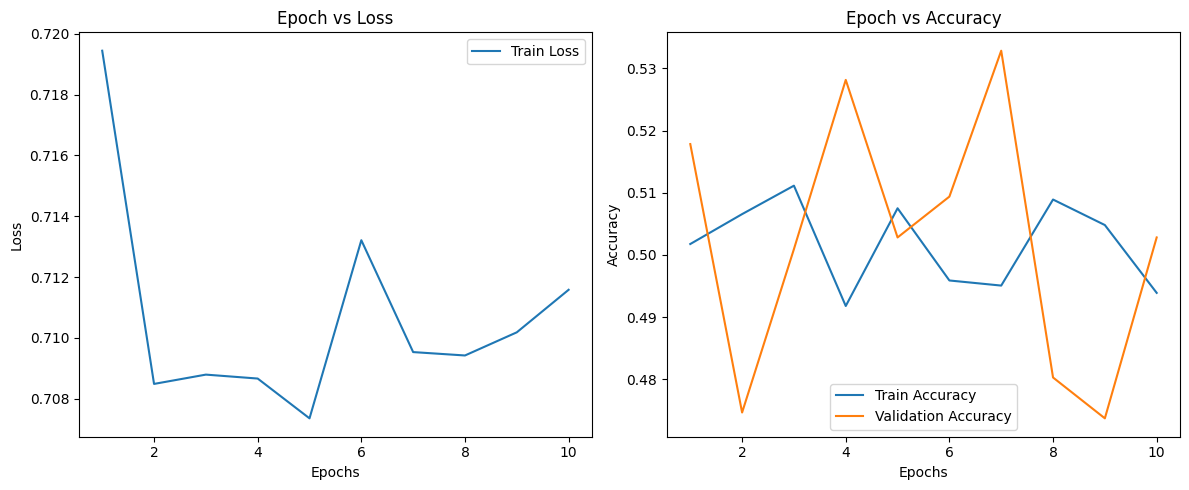

In [61]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [62]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_last, test_loader)
test_accuracies['RNN Last Hidden State'] = test_acc
print(f'Test Accuracy (RNN Last Hidden State): {test_acc:.4f}')

Test Accuracy (RNN Last Hidden State): 0.4953


### 2) RNN Max Pooling

In [63]:
# Call grid search
best_hyperparams_RNN_max = run_grid_search(MaxPoolingRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                           validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6922, Train Acc: 0.5165, Val Acc: 0.5450
Epoch 2, Train Loss: 0.6913, Train Acc: 0.5305, Val Acc: 0.5507
Epoch 3, Train Loss: 0.6909, Train Acc: 0.5351, Val Acc: 0.5619
Epoch 4, Train Loss: 0.6900, Train Acc: 0.5542, Val Acc: 0.5966
Epoch 5, Train Loss: 0.6887, Train Acc: 0.5739, Val Acc: 0.6088
Epoch 6, Train Loss: 0.6886, Train Acc: 0.5754, Val Acc: 0.6051
Epoch 7, Train Loss: 0.6875, Train Acc: 0.5841, Val Acc: 0.6248
Epoch 8, Train Loss: 0.6874, Train Acc: 0.5845, Val Acc: 0.6295
Epoch 9, Train Loss: 0.6863, Train Acc: 0.6001, Val Acc: 0.6332
Epoch 10, Train Loss: 0.6850, Train Acc: 0.6144, Val Acc: 0.6492
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5508, Train Acc: 0.7110, Val Acc: 0.6529
Epoch 2, Train Loss: 0.4799, Train Acc: 0.7696, Val Acc: 0.7683
Epoch 3, Train Loss: 0.4527, Train Acc: 0.7845, Val Acc: 0.7739
Epoch 4, Train Loss: 0.4417, Train Acc: 0.7926, Val Acc: 0.7

In [64]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_max['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [65]:
# Retrain using best hyperparameters
best_model_RNN_max = MaxPoolingRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_max['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])

best_model_RNN_max, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_max, train_loader, validation_loader,
                                                                                 best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5610, Train Acc: 0.7000, Val Acc: 0.7645
Epoch 2, Train Loss: 0.4685, Train Acc: 0.7804, Val Acc: 0.7814
Epoch 3, Train Loss: 0.4521, Train Acc: 0.7824, Val Acc: 0.7739
Epoch 4, Train Loss: 0.4222, Train Acc: 0.8013, Val Acc: 0.7580
Epoch 5, Train Loss: 0.4097, Train Acc: 0.8117, Val Acc: 0.7917
Epoch 6, Train Loss: 0.3941, Train Acc: 0.8257, Val Acc: 0.7824
Epoch 7, Train Loss: 0.3775, Train Acc: 0.8292, Val Acc: 0.7523
Epoch 8, Train Loss: 0.3602, Train Acc: 0.8395, Val Acc: 0.7880
Early stopping


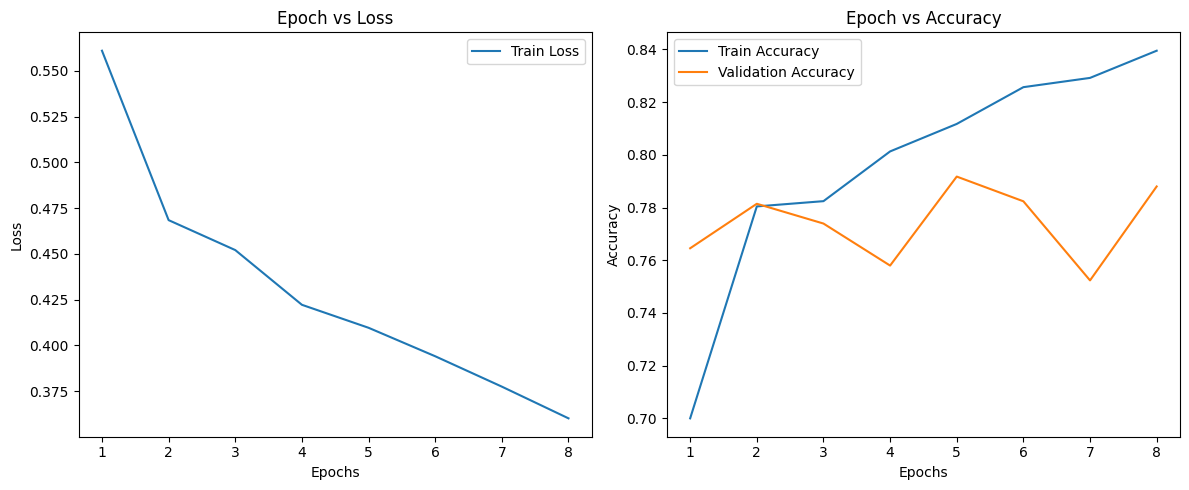

In [66]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [67]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_max, test_loader)
test_accuracies['RNN Max Pooling'] = test_acc
print(f'Test Accuracy (RNN Max Pooling): {test_acc:.4f}')

Test Accuracy (RNN Max Pooling): 0.7964


### 3) RNN Average Pooling

In [68]:
# Call grid search
best_hyperparams_RNN_avg = run_grid_search(AveragePoolingRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6937, Train Acc: 0.4836, Val Acc: 0.5094
Epoch 2, Train Loss: 0.6935, Train Acc: 0.4873, Val Acc: 0.5150
Epoch 3, Train Loss: 0.6932, Train Acc: 0.4996, Val Acc: 0.5225
Epoch 4, Train Loss: 0.6931, Train Acc: 0.5072, Val Acc: 0.5263
Epoch 5, Train Loss: 0.6929, Train Acc: 0.5149, Val Acc: 0.5582
Epoch 6, Train Loss: 0.6927, Train Acc: 0.5193, Val Acc: 0.5675
Epoch 7, Train Loss: 0.6926, Train Acc: 0.5367, Val Acc: 0.5713
Epoch 8, Train Loss: 0.6923, Train Acc: 0.5431, Val Acc: 0.5704
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.6630, Train Acc: 0.5992, Val Acc: 0.6407
Epoch 2, Train Loss: 0.6079, Train Acc: 0.6719, Val Acc: 0.6417
Epoch 3, Train Loss: 0.5766, Train Acc: 0.6958, Val Acc: 0.6379
Epoch 4, Train Loss: 0.5632, Train Acc: 0.7110, Val Acc: 0.7298
Epoch 5, Train Loss: 0.5603, Train Acc: 0.7120, Val Acc: 0.6482
Epoch 6, Train Loss: 0.5613, Train Acc: 0.7107, Val Acc: 0.71

In [69]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_avg['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [70]:
# Retrain using best hyperparameters
best_model_RNN_avg = AveragePoolingRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_avg['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])

best_model_RNN_avg, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_avg, train_loader, validation_loader,
                                                                                 best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6877, Train Acc: 0.5522, Val Acc: 0.6276
Epoch 2, Train Loss: 0.6248, Train Acc: 0.6619, Val Acc: 0.7111
Epoch 3, Train Loss: 0.5791, Train Acc: 0.7150, Val Acc: 0.7205
Epoch 4, Train Loss: 0.5442, Train Acc: 0.7245, Val Acc: 0.7448
Epoch 5, Train Loss: 0.5261, Train Acc: 0.7430, Val Acc: 0.6970
Epoch 6, Train Loss: 0.5333, Train Acc: 0.7286, Val Acc: 0.7467
Epoch 7, Train Loss: 0.5265, Train Acc: 0.7401, Val Acc: 0.7448
Epoch 8, Train Loss: 0.5194, Train Acc: 0.7417, Val Acc: 0.7533


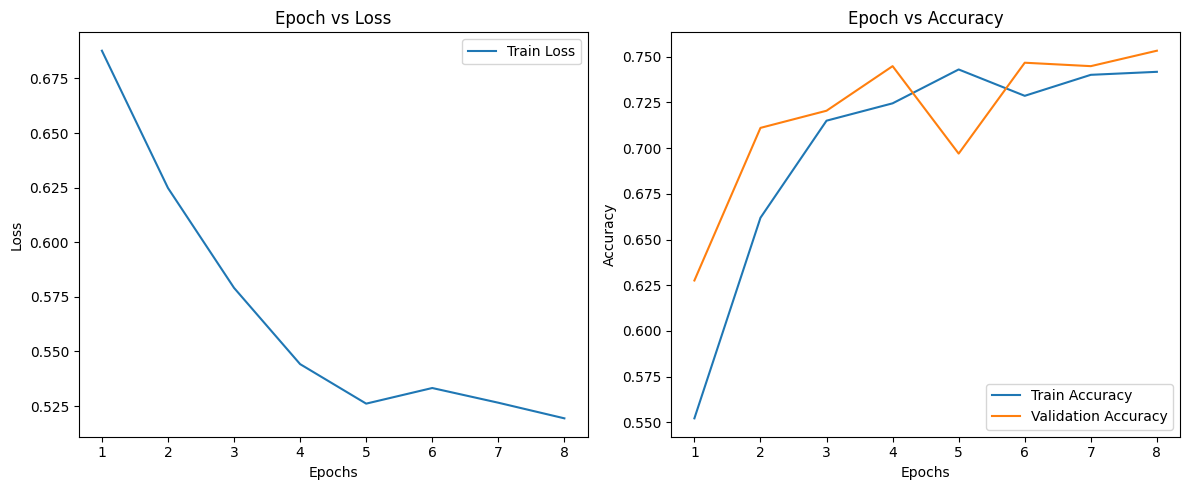

In [71]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [72]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_avg, test_loader)
test_accuracies['RNN Average Pooling'] = test_acc
print(f'Test Accuracy (RNN Average Pooling): {test_acc:.4f}')

Test Accuracy (RNN Average Pooling): 0.7589


In [73]:
test_accuracies

{'RNN Last Hidden State': 0.49530956848030017,
 'RNN Max Pooling': 0.7964352720450282,
 'RNN Average Pooling': 0.7589118198874296}

**Max pooling** achieved the highest test accuracy of 0.7923.    
Thus, in the following sectinos we will apply max pooling to derive the final sentence representation to perform sentiment classification.

# Part 3: Enhancement

The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In  this section, you will design strategies to improve upon the previous model you have built. You ar
 required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards a meaningful improvement.

## Question 3: Enhancement

### (a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).

Set `freeze=False` when initializing the embedding layer to allow word embeddings update.

In [139]:
class MaxPoolingRNNModelUpdate(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPoolingRNNModelUpdate, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Max pooling over all hidden states
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.fc(max_pooled)
        return output

In [141]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

# Call grid search
best_hyperparams_RNN_update = run_grid_search(MaxPoolingRNNModelUpdate, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6936, Train Acc: 0.5048, Val Acc: 0.5019
Epoch 2, Train Loss: 0.6928, Train Acc: 0.5057, Val Acc: 0.5328
Epoch 3, Train Loss: 0.6920, Train Acc: 0.5333, Val Acc: 0.5478
Epoch 4, Train Loss: 0.6907, Train Acc: 0.5355, Val Acc: 0.5553
Epoch 5, Train Loss: 0.6904, Train Acc: 0.5563, Val Acc: 0.5816
Epoch 6, Train Loss: 0.6891, Train Acc: 0.5651, Val Acc: 0.5901
Epoch 7, Train Loss: 0.6883, Train Acc: 0.5754, Val Acc: 0.5891
Epoch 8, Train Loss: 0.6873, Train Acc: 0.5804, Val Acc: 0.6032
Epoch 9, Train Loss: 0.6865, Train Acc: 0.5880, Val Acc: 0.6304
Epoch 10, Train Loss: 0.6851, Train Acc: 0.6064, Val Acc: 0.6191
Epoch 11, Train Loss: 0.6842, Train Acc: 0.6177, Val Acc: 0.6173
Epoch 12, Train Loss: 0.6831, Train Acc: 0.6225, Val Acc: 0.6276
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5217, Train Acc: 0.7334, Val Acc: 0.7514
Epoch 2, Train Loss: 0.3308, Train Acc: 0.8

In [142]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_update['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [172]:
# Retrain using best hyperparameters
best_model_RNN_update = MaxPoolingRNNModelUpdate(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_update['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])

best_model_RNN_update, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_update, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6900, Train Acc: 0.5307, Val Acc: 0.5732
Epoch 2, Train Loss: 0.6767, Train Acc: 0.6080, Val Acc: 0.6895
Epoch 3, Train Loss: 0.6219, Train Acc: 0.6696, Val Acc: 0.5713
Epoch 4, Train Loss: 0.5553, Train Acc: 0.7145, Val Acc: 0.7317
Epoch 5, Train Loss: 0.5169, Train Acc: 0.7444, Val Acc: 0.5638
Epoch 6, Train Loss: 0.4980, Train Acc: 0.7572, Val Acc: 0.7326
Epoch 7, Train Loss: 0.4820, Train Acc: 0.7699, Val Acc: 0.7552
Epoch 8, Train Loss: 0.4730, Train Acc: 0.7725, Val Acc: 0.7777
Epoch 9, Train Loss: 0.4572, Train Acc: 0.7812, Val Acc: 0.7805
Epoch 10, Train Loss: 0.4511, Train Acc: 0.7899, Val Acc: 0.7186
Epoch 11, Train Loss: 0.4380, Train Acc: 0.7989, Val Acc: 0.7608


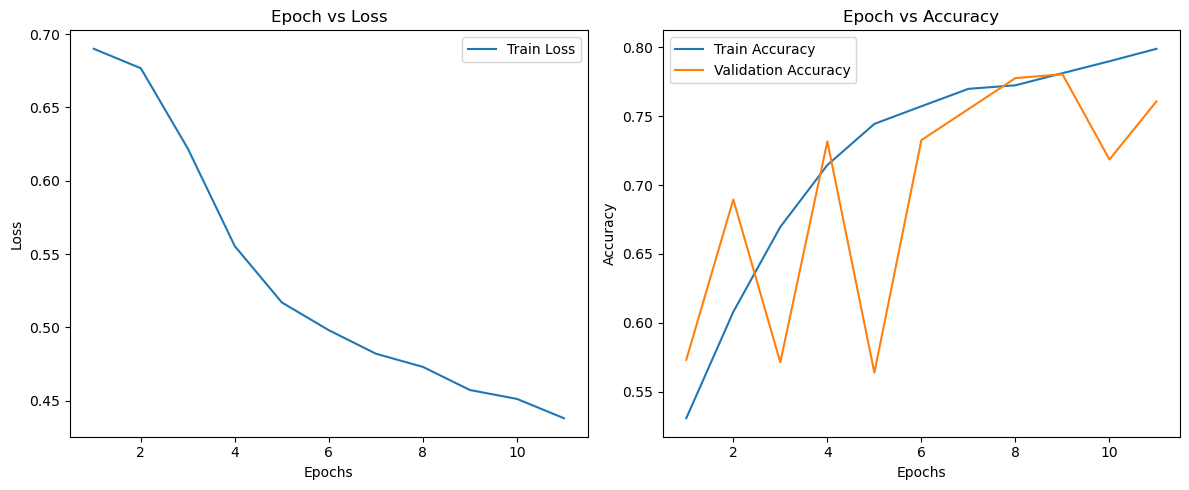

In [173]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [174]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_update, test_loader)
test_accuracies['RNN (Update Word Embeddings)'] = test_acc
print(f'Test Accuracy (Update Word Embeddings): {test_acc:.4f}')

Test Accuracy (Update Word Embeddings): 0.7871


### (b) Report the accuracy score on the test set when applying your method to deal with OOV words in Part 3.2.

In [49]:
# Initialize the embedding matrix
embedding_matrix_cosine_sim = np.zeros((vocab_size, embedding_dim))

# Map vocabulary to embedding matrix
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Populate embedding matrix and handle OOV words
for word, idx in word_to_idx.items():
    if word in word2vec_model:
        embedding_matrix_cosine_sim[idx] = word2vec_model[word]
    else:
        # Handle OOV words
        replacement_word = find_replacement_word(word, word2vec_model)

        if replacement_word:
            embedding_matrix_cosine_sim[idx] = word2vec_model[replacement_word]  # Use replacement word vector
        else:
            embedding_matrix_cosine_sim[idx] = np.random.normal(size=(embedding_dim,))  # Random initialization if no replacement found

In [50]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) Freeze Word Embeddings

In [51]:
# Call grid search
best_hyperparams_OOV_freeze = run_grid_search(MaxPoolingRNNModel, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                              validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6959, Train Acc: 0.5141, Val Acc: 0.5047
Epoch 2, Train Loss: 0.6952, Train Acc: 0.5077, Val Acc: 0.5141
Epoch 3, Train Loss: 0.6933, Train Acc: 0.5215, Val Acc: 0.5206
Epoch 4, Train Loss: 0.6938, Train Acc: 0.5212, Val Acc: 0.5244
Epoch 5, Train Loss: 0.6921, Train Acc: 0.5245, Val Acc: 0.5310
Epoch 6, Train Loss: 0.6918, Train Acc: 0.5209, Val Acc: 0.5347
Epoch 7, Train Loss: 0.6912, Train Acc: 0.5277, Val Acc: 0.5310
Epoch 8, Train Loss: 0.6895, Train Acc: 0.5343, Val Acc: 0.5281
Epoch 9, Train Loss: 0.6902, Train Acc: 0.5300, Val Acc: 0.5366
Epoch 10, Train Loss: 0.6882, Train Acc: 0.5394, Val Acc: 0.5413
Epoch 11, Train Loss: 0.6892, Train Acc: 0.5429, Val Acc: 0.5441
Epoch 12, Train Loss: 0.6894, Train Acc: 0.5302, Val Acc: 0.5356
Epoch 13, Train Loss: 0.6896, Train Acc: 0.5373, Val Acc: 0.5413
Epoch 14, Train Loss: 0.6883, Train Acc: 0.5342, Val Acc: 0.5375
Early stopping
Training with lr=0.001, batch_s

In [52]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_OOV_freeze['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [53]:
# Retrain using best hyperparameters
best_model_OOV_freeze = MaxPoolingRNNModel(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_OOV_freeze['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])

best_model_OOV_freeze, train_losses, train_accuracies, val_accuracies = train_model(best_model_OOV_freeze, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6863, Train Acc: 0.5515, Val Acc: 0.6388
Epoch 2, Train Loss: 0.5976, Train Acc: 0.6769, Val Acc: 0.7111
Epoch 3, Train Loss: 0.5374, Train Acc: 0.7293, Val Acc: 0.7561
Epoch 4, Train Loss: 0.5035, Train Acc: 0.7533, Val Acc: 0.7674
Epoch 5, Train Loss: 0.4961, Train Acc: 0.7546, Val Acc: 0.7326
Epoch 6, Train Loss: 0.4705, Train Acc: 0.7748, Val Acc: 0.7467
Epoch 7, Train Loss: 0.4709, Train Acc: 0.7754, Val Acc: 0.7674
Early stopping


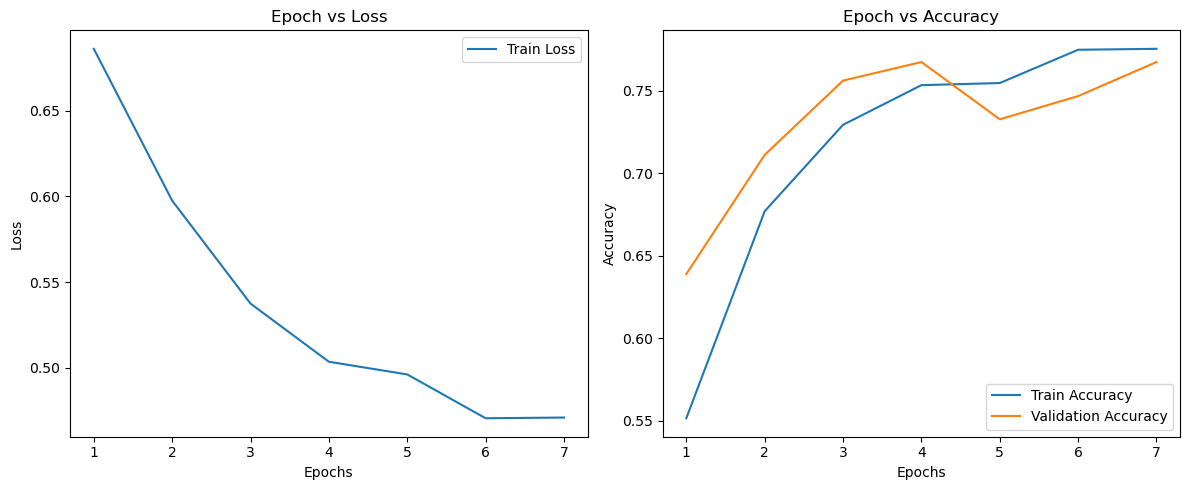

In [54]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [55]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_OOV_freeze, test_loader)
test_accuracies['RNN (Handle OOV)'] = test_acc
print(f'Test Accuracy (Handle OOV): {test_acc:.4f}')

Test Accuracy (Handle OOV): 0.7777


### 2) Update Word Embeddings

In [65]:
# Call grid search
best_hyperparams_OOV_update = run_grid_search(MaxPoolingRNNModelUpdate, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6953, Train Acc: 0.5069, Val Acc: 0.5141
Epoch 2, Train Loss: 0.6943, Train Acc: 0.5185, Val Acc: 0.5356
Epoch 3, Train Loss: 0.6932, Train Acc: 0.5223, Val Acc: 0.5216
Epoch 4, Train Loss: 0.6926, Train Acc: 0.5266, Val Acc: 0.5356
Epoch 5, Train Loss: 0.6916, Train Acc: 0.5322, Val Acc: 0.5375
Epoch 6, Train Loss: 0.6930, Train Acc: 0.5134, Val Acc: 0.5403
Epoch 7, Train Loss: 0.6917, Train Acc: 0.5237, Val Acc: 0.5028
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.6478, Train Acc: 0.6050, Val Acc: 0.7402
Epoch 2, Train Loss: 0.4244, Train Acc: 0.8086, Val Acc: 0.7589
Epoch 3, Train Loss: 0.2582, Train Acc: 0.8953, Val Acc: 0.7570
Epoch 4, Train Loss: 0.1499, Train Acc: 0.9470, Val Acc: 0.7514
Epoch 5, Train Loss: 0.0942, Train Acc: 0.9680, Val Acc: 0.7598
Epoch 6, Train Loss: 0.0587, Train Acc: 0.9814, Val Acc: 0.7336
Epoch 7, Train Loss: 0.0381, Train Acc: 0.9872, Val Acc: 0.73

In [71]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_OOV_update['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [73]:
# Retrain using best hyperparameters
best_model_OOV_update = MaxPoolingRNNModelUpdate(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_OOV_update['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])

best_model_OOV_update, train_losses, train_accuracies, val_accuracies = train_model(best_model_OOV_update, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7022, Train Acc: 0.5472, Val Acc: 0.6445
Epoch 2, Train Loss: 0.5023, Train Acc: 0.7598, Val Acc: 0.7777
Epoch 3, Train Loss: 0.3529, Train Acc: 0.8478, Val Acc: 0.7861
Epoch 4, Train Loss: 0.2547, Train Acc: 0.8950, Val Acc: 0.7805
Epoch 5, Train Loss: 0.1910, Train Acc: 0.9224, Val Acc: 0.7739
Epoch 6, Train Loss: 0.1391, Train Acc: 0.9513, Val Acc: 0.7486
Early stopping


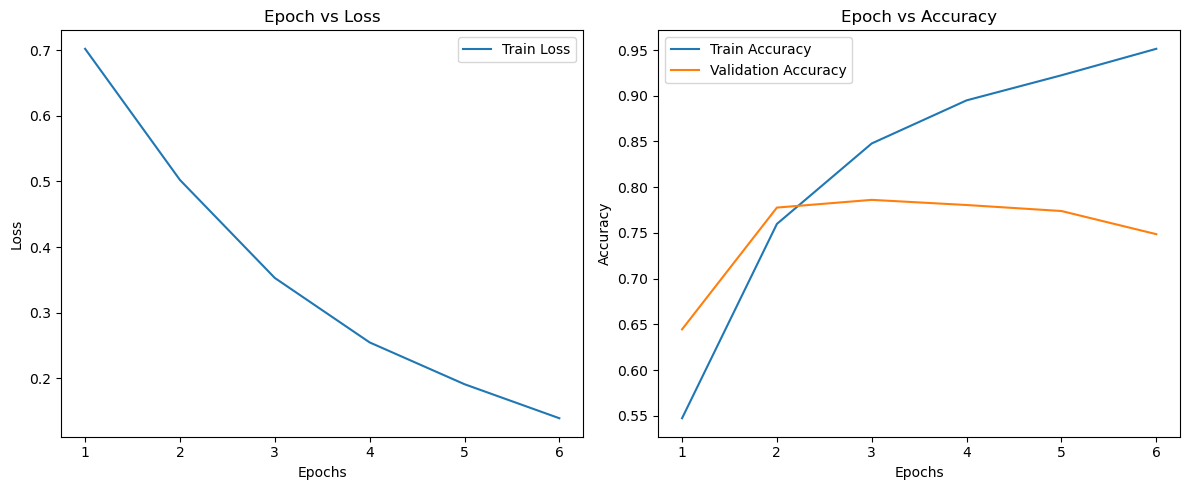

In [74]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [75]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_OOV_update, test_loader)
test_accuracies['RNN (Handle OOV with Word Embeddings Update)'] = test_acc
print(f'Test Accuracy (Handle OOV with Word Embeddings Update): {test_acc:.4f}')

Test Accuracy (Handle OOV with Word Embeddings Update): 0.7711


### (c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).

In [79]:
# Define BiLSTM and BiGRU models
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)  # Multiplied by 2 for bidirection
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        lstm_output, _ = self.lstm(embedded)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply max pooling over the output of the LSTM
        max_pooled, _ = torch.max(lstm_output, dim=1)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(max_pooled)
        return output

class BiGRUModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(BiGRUModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)  # Multiplied by 2 for bidirection
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        gru_output, _ = self.gru(embedded)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply max pooling over the output of the GRU
        max_pooled, _ = torch.max(gru_output, dim=1)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(max_pooled)
        return output

In [81]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) biLSTM

In [84]:
# Call grid search
best_hyperparams_biLSTM = run_grid_search(BiLSTMModel, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                          validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6930, Train Acc: 0.5094, Val Acc: 0.5310
Epoch 2, Train Loss: 0.6925, Train Acc: 0.5104, Val Acc: 0.5366
Epoch 3, Train Loss: 0.6923, Train Acc: 0.5206, Val Acc: 0.5338
Epoch 4, Train Loss: 0.6914, Train Acc: 0.5285, Val Acc: 0.5319
Epoch 5, Train Loss: 0.6911, Train Acc: 0.5199, Val Acc: 0.5253
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5548, Train Acc: 0.6979, Val Acc: 0.7861
Epoch 2, Train Loss: 0.3093, Train Acc: 0.8696, Val Acc: 0.7674
Epoch 3, Train Loss: 0.1451, Train Acc: 0.9455, Val Acc: 0.7702
Epoch 4, Train Loss: 0.0666, Train Acc: 0.9755, Val Acc: 0.7711
Early stopping
Training with lr=0.001, batch_size=16, optimizer=RMSprop
Epoch 1, Train Loss: 0.5358, Train Acc: 0.7237, Val Acc: 0.7495
Epoch 2, Train Loss: 0.3124, Train Acc: 0.8678, Val Acc: 0.7542
Epoch 3, Train Loss: 0.1905, Train Acc: 0.9256, Val Acc: 0.7730
Epoch 4, Train Loss: 0.1118, Train Acc

In [85]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_biLSTM['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [86]:
# Retrain using best hyperparameters
best_model_biLSTM = BiLSTMModel(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_biLSTM['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])

best_model_biLSTM, train_losses, train_accuracies, val_accuracies = train_model(best_model_biLSTM, train_loader, validation_loader,
                                                                                best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5640, Train Acc: 0.6877, Val Acc: 0.7711
Epoch 2, Train Loss: 0.2600, Train Acc: 0.8931, Val Acc: 0.7674
Epoch 3, Train Loss: 0.0757, Train Acc: 0.9747, Val Acc: 0.7683
Epoch 4, Train Loss: 0.0229, Train Acc: 0.9924, Val Acc: 0.7448
Early stopping


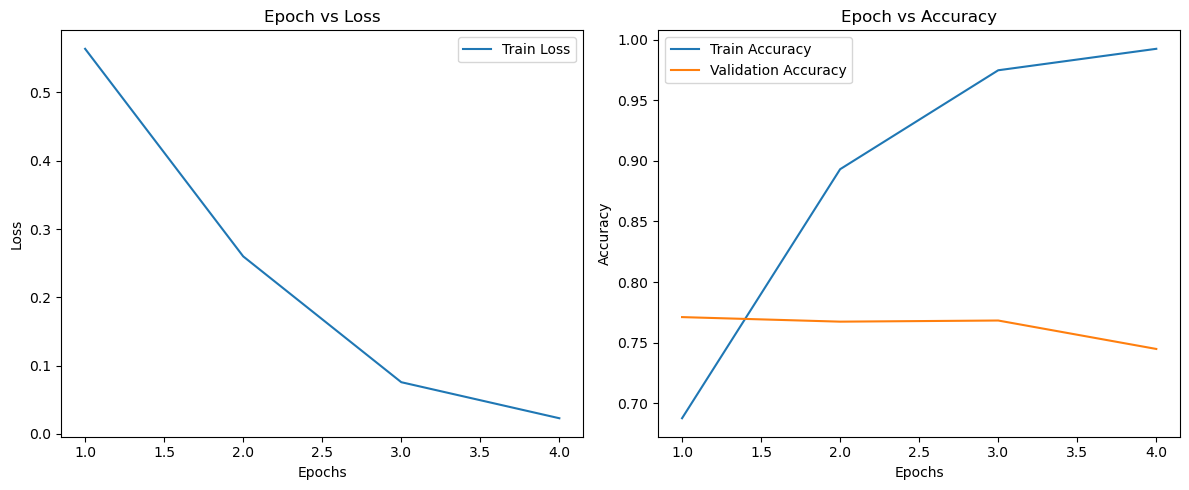

In [87]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [88]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_biLSTM, test_loader)
test_accuracies['biLSTM'] = test_acc
print(f'Test Accuracy (biLSTM): {test_acc:.4f}')

Test Accuracy (biLSTM): 0.7833


### 2) biGRU

In [89]:
# Call grid search
best_hyperparams_biGRU = run_grid_search(BiGRUModel, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                         validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6924, Train Acc: 0.5163, Val Acc: 0.5235
Epoch 2, Train Loss: 0.6915, Train Acc: 0.5253, Val Acc: 0.5319
Epoch 3, Train Loss: 0.6902, Train Acc: 0.5299, Val Acc: 0.5375
Epoch 4, Train Loss: 0.6896, Train Acc: 0.5368, Val Acc: 0.5197
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5401, Train Acc: 0.7106, Val Acc: 0.7749
Epoch 2, Train Loss: 0.2991, Train Acc: 0.8725, Val Acc: 0.7833
Epoch 3, Train Loss: 0.1335, Train Acc: 0.9483, Val Acc: 0.7749
Epoch 4, Train Loss: 0.0532, Train Acc: 0.9815, Val Acc: 0.7505
Training with lr=0.001, batch_size=16, optimizer=RMSprop
Epoch 1, Train Loss: 0.5482, Train Acc: 0.7145, Val Acc: 0.6726
Epoch 2, Train Loss: 0.3146, Train Acc: 0.8605, Val Acc: 0.8039
Epoch 3, Train Loss: 0.1893, Train Acc: 0.9250, Val Acc: 0.7964
Epoch 4, Train Loss: 0.1024, Train Acc: 0.9618, Val Acc: 0.7880
Training with lr=0.001, batch_size=32, optimizer=SGD
Epoch 1, Train 

In [90]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_biGRU['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [91]:
# Retrain using best hyperparameters
best_model_biGRU = BiGRUModel(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_biGRU['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])

best_model_biGRU, train_losses, train_accuracies, val_accuracies = train_model(best_model_biGRU, train_loader, validation_loader,
                                                                               best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5500, Train Acc: 0.7147, Val Acc: 0.7589
Epoch 2, Train Loss: 0.3142, Train Acc: 0.8654, Val Acc: 0.7692
Epoch 3, Train Loss: 0.1946, Train Acc: 0.9217, Val Acc: 0.7054
Epoch 4, Train Loss: 0.1091, Train Acc: 0.9617, Val Acc: 0.7073


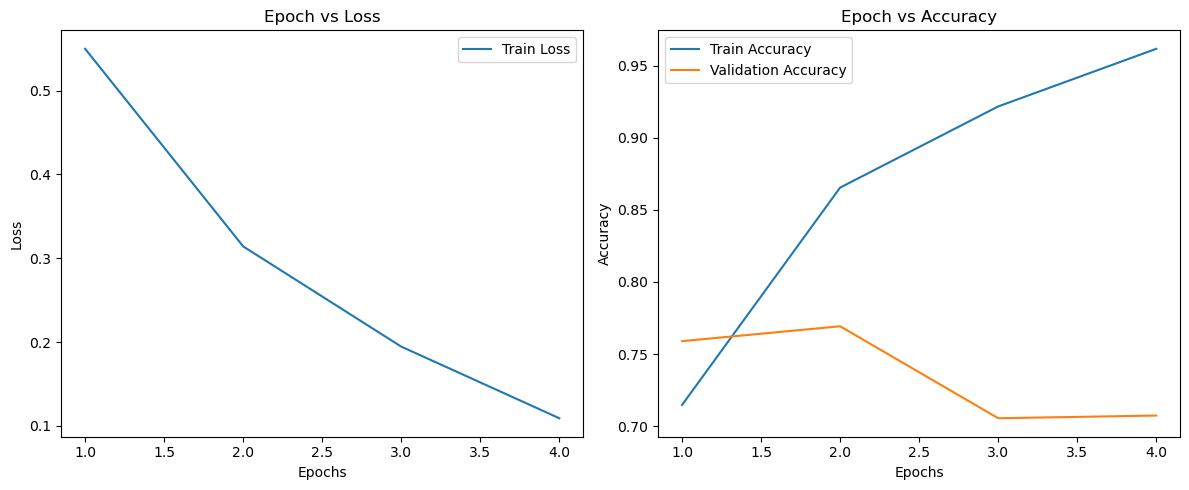

In [92]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [93]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_biGRU, test_loader)
test_accuracies['biGRU'] = test_acc
print(f'Test Accuracy (biGRU): {test_acc:.4f}')

Test Accuracy (biGRU): 0.7270


### (d) Report the accuracy scores of CNN on the test set (Part 3.4).

In [95]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, embedding_matrix, output_dim):
        super(CNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.conv1 = nn.Conv2d(1, 100, (3, embedding_dim)).to(device)  # 1 input channel, 100 output channels
        self.fc = nn.Linear(100, output_dim).to(device)
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)  # Add channel dimension
        conv_out = self.conv1(embedded).squeeze(3)  # Shape: (batch_size, 100, sequence_length - filter_size + 1)
        conv_out = torch.relu(conv_out)  # Apply ReLU
        pooled = nn.functional.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)  # Max pooling
        output = self.fc(self.dropout(pooled))
        return output

In [96]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

In [100]:
best_val_acc = 0
best_hyperparams_CNN = {}

# Prepare datasets
train_data = TensorDataset(train_sequences.to(device), train_labels.to(device))
validation_data = TensorDataset(validation_sequences.to(device), validation_labels.to(device))

# Grid search
for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

            # Set up DataLoader with the current batch size
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

            # Initialize a new model for each set of hyperparameters
            model = CNNModel(embedding_matrix=embedding_matrix_cosine_sim, output_dim=output_dim)  # Reinitialize model
            model = model.to(device)

            # Choose optimizer
            if opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)

            # Train and evaluate the model
            val_acc, _, _, _ = train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)


            # Track the best configuration based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

print(f"Best Validation Accuracy: {best_val_acc}")
print(f"Best Hyperparameters: {best_hyperparams}")

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.7022, Train Acc: 0.5027, Val Acc: 0.5103
Epoch 2, Train Loss: 0.6938, Train Acc: 0.5220, Val Acc: 0.5272
Epoch 3, Train Loss: 0.6918, Train Acc: 0.5322, Val Acc: 0.5516
Epoch 4, Train Loss: 0.6899, Train Acc: 0.5345, Val Acc: 0.5338
Epoch 5, Train Loss: 0.6875, Train Acc: 0.5444, Val Acc: 0.5638
Epoch 6, Train Loss: 0.6860, Train Acc: 0.5495, Val Acc: 0.5450
Epoch 7, Train Loss: 0.6837, Train Acc: 0.5512, Val Acc: 0.5629
Epoch 8, Train Loss: 0.6852, Train Acc: 0.5502, Val Acc: 0.5629
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.6322, Train Acc: 0.6351, Val Acc: 0.7711
Epoch 2, Train Loss: 0.3882, Train Acc: 0.8328, Val Acc: 0.7552
Epoch 3, Train Loss: 0.2085, Train Acc: 0.9208, Val Acc: 0.7570
Epoch 4, Train Loss: 0.0906, Train Acc: 0.9691, Val Acc: 0.7617
Early stopping
Training with lr=0.001, batch_size=16, optimizer=RMSprop
Epoch 1, Train Loss: 0.6705, Train Acc

In [117]:
best_hyperparams_CNN = best_hyperparams

In [119]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_CNN['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [123]:
# Retrain using best hyperparameters
best_model_CNN = CNNModel(embedding_matrix_cosine_sim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_CNN['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])

best_model_CNN, train_losses, train_accuracies, val_accuracies = train_model(best_model_CNN, train_loader, validation_loader,
                                                                             best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6723, Train Acc: 0.6367, Val Acc: 0.7523
Epoch 2, Train Loss: 0.4092, Train Acc: 0.8164, Val Acc: 0.7730
Epoch 3, Train Loss: 0.2734, Train Acc: 0.8890, Val Acc: 0.7636
Epoch 4, Train Loss: 0.1717, Train Acc: 0.9361, Val Acc: 0.7655
Epoch 5, Train Loss: 0.1001, Train Acc: 0.9644, Val Acc: 0.7702
Early stopping


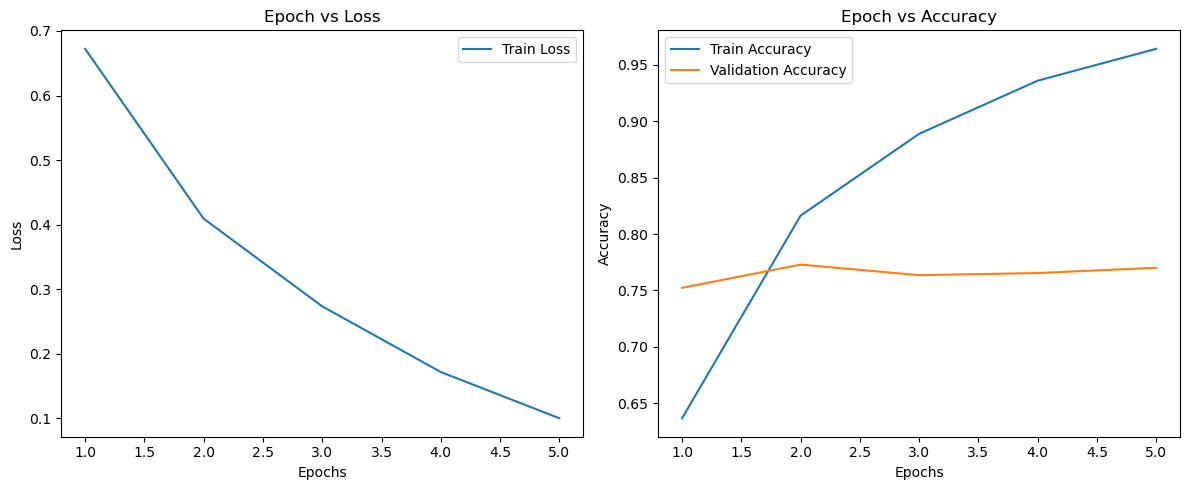

In [124]:
epochs = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs, train_losses, train_accuracies, val_accuracies)

In [125]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_CNN, test_loader)
test_accuracies['CNN'] = test_acc
print(f'Test Accuracy (CNN): {test_acc:.4f}')

Test Accuracy (CNN): 0.7795


### (e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set using your improved model.

### Ensemble Methods

This setup aggregates the model predictions by averaging the class probabilities across each model, then assigns the final prediction based on the highest average probability. This approach should increase overall stability and potentially improve the test accuracy of your sentiment classification task by leveraging the diverse perspectives of different models.

In [185]:
def ensemble_predict(models, data_loader):
    all_probs = []

    # Collect prediction probabilities from each model
    for model in models:
        model.eval()  # Set to evaluation mode
        model_probs = []
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                model_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
        all_probs.append(np.vstack(model_probs))

    # Average the probabilities across models
    avg_probs = np.mean(all_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=1)
    
    return final_preds

In [187]:
def compute_ensemble_accuracy(models, test_loader, test_labels):
    # Get ensemble predictions
    ensemble_preds = ensemble_predict(models, test_loader)

    # Calculate accuracy
    accuracy = np.mean(ensemble_preds == test_labels.numpy())
    print(f'Test Accuracy (Ensemble): {accuracy:.4f}')
    
    return accuracy

In [189]:
trained_models = [best_model_RNN_update, best_model_OOV_update, best_model_biLSTM, best_model_CNN]

# Compute ensemble accuracy on the test set
test_acc = compute_ensemble_accuracy(trained_models, test_loader, test_labels)
test_accuracies['Ensemble'] = test_acc

Test Accuracy (Ensemble): 0.8124


From the test accuracies, we see that when employing **ensemble method with soft voting (probability averaging)** gives us a higher test accuracy compared to the test accuracies of each individual model.

###  (f) Compare the results across different solutions above and describe your observations with possible discussions.

In [193]:
test_accuracies

{'RNN (Handle OOV)': 0.7776735459662288,
 'RNN (Handle OOV with Word Embeddings Update)': 0.7711069418386491,
 'biLSTM': 0.7833020637898687,
 'biGRU': 0.7270168855534709,
 'CNN': 0.7795497185741088,
 'RNN (Update Word Embeddings)': 0.7870544090056285,
 'Ensemble': 0.8123827392120075}